In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.infer import Predictive
import pyro.optim as optim
from IPython.display import Image

Variables:
- observable or latent.
- data or parameters.
- parameteric, non-parametric estimation.
- discrete or continuous.
- can be defined in random or deterministic way.

Examples:

Flipping coin: 

$P(X| \nu) =  \nu^X(1-\nu)^{1- X}$, $\nu \in [0, 1]$.

$P(X = head | \nu) =  \nu$, $\nu \in [0, 1]$.

We observe $X$ but can not observe $\nu$.

$X$ in this is data, $\nu$ is a parameter.
$X$ is discrete, $\nu$ is continuous.

Another example, let $C$ be defined as $A+B$


$P(C | A, B) = 1$, if $C = A+B$, 0, if $C \neq A+B$.

Usual setting: 

we observe data $X$, we make some assumptions about $P(X | \beta)$, the process that generates the data,
and about the parameters of this process $P(\beta)$.

In that frame of mind we write:

$P(\beta | X) = \frac{P(X | \beta) P(\beta)}{P(X)}$

and call $P(\beta)$ prior, something we suppose the parameters of the process that generates the data,
$P(\beta | X)$ - posterior, something that we learn about the parameters after having see the data. 
Then $P(X | \beta)$ is the likelihood of the data given a fixed parameter.

## Probabilistic Progamming Language

PPL has a way to specify $P(X | \beta)$ and $P(\beta | \theta)$ to obtain $P(\beta | X)$.

Well, they can be just functions. 

Learning the posterior numerically : Metropolis-Hastings algorithm.

$P(\beta | X) - ?$.

For a given $\beta$ we can evaluate $P(X | \beta)$ and $P(\beta | \theta)$.

So we sample the space of $\beta$ by simulating a Markov process: jumping with a kernel $Q(\beta, \beta')$.
That is usually taken to be symmetric and Gaussian.

We accept the jump with a certain threshold probability. In that case regions with highed $P(\beta)$ will have more samples and their density will approximate the posterior.

![title](img/Illustration-of-Markov-Chain-Monte-Carlo-method.ppm)

`source : https://www.researchgate.net/publication/334001505_Adaptive_Markov_chain_Monte_Carlo_algorithms_for_Bayesian_inference_recent_advances_and_comparative_study`

In [2]:
from numpy.random import RandomState
rns = RandomState(11)

obs = rns.binomial(1, 0.7, 10)
obs 

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 0])

In [3]:
rns.beta(5, 5, 10)

array([0.40086487, 0.67431091, 0.44709169, 0.47353209, 0.41837195,
       0.6491808 , 0.56082703, 0.65348877, 0.53443872, 0.50289448])

In [4]:
def likelihood(x, nu):
    return nu**x*(1 - nu)**(1 - x)

np.sum(np.log(likelihood(obs, 0.5))), np.sum(np.log(likelihood(obs, 0.6))), np.sum(np.log(likelihood(obs, 0.7)))

(-6.931471805599453, -6.3246515619844, -6.108643020548935)

## Pyro vocabulary

- a stochastic function ~ random variable: represents (A, B) -> C
- `pyro.sample` primitive
- pyro guide

Random variables (not always random) in Pyro can be

- deterministic Python code
- primitive stochastic functions (random)

A stochastic function can be any Python object with a `__call__()` method, like a function, a method, or a PyTorch `nn.Module`.

In [5]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

conditioned_scale = pyro.condition(weather, data={"cloudy": 1})

for _ in range(3):
    print(weather())

('sunny', 75.98052215576172)
('cloudy', 51.125267028808594)
('sunny', 58.054649353027344)


pyro.sample is instantiating an rv, and assigns to it a name (in the context)

Procedurally, `weather()` is still a non-deterministic Python callable that returns two random samples. 

Because the randomness is now invoked with `pyro.sample`, however, it is much more than that. In particular `weather()` specifies a joint probability distribution over two named random variables: `cloudy` and `temp`. 

As such, it defines a probabilistic model that we can reason about using the techniques of probability theory. 

For example we might ask:if I observe a temperature of 70 degrees, how likely is it to be cloudy?

## Conditioning

## Pyro guide

- all unobserved sample statements that appear in the model appear in the guide.
- the guide has the same input signature as the model (i.e., takes the same arguments)

## Bernoulli example

In [48]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pandas as pd


# clear the param store in case we're in a REPL
pyro.clear_param_store()

n_steps = 50000

data = []
for _ in range(900):
    data.append(torch.tensor(1.0))
for _ in range(100):
    data.append(torch.tensor(0.0))
    
data = torch.FloatTensor(data)

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(0.5)
    beta0 = torch.tensor(0.5)
    # sample f from the beta prior
    f = pyro.sample("nu", dist.Beta(alpha0, beta0))
    # loop over the observed data
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(5.5),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(5.5),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("nu", dist.Beta(alpha_q, beta_q))

In [49]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [50]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(n_steps):
    losses += [svi.step(data)]
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
based on the data and our prior belief, the fairness of the coin is 0.898 +- 0.024


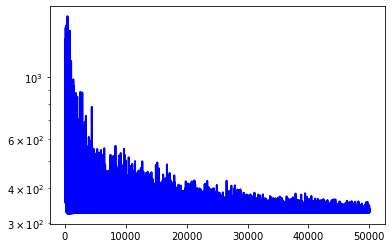

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(losses, color='blue', lw=2)

# ax = plt.plot(losses)
ax.set_yscale('log')

In [52]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if not 'obs' in k}

In [53]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: nu
       mean       std        5%       25%       50%     75%       95%
0  0.898297  0.024568  0.856456  0.882452  0.899965  0.9157  0.936023 



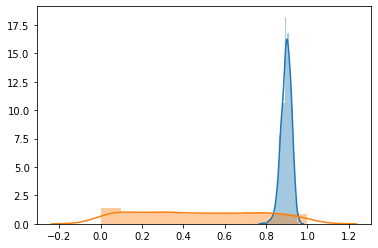

In [54]:
sns.distplot(svi_samples['nu'], label='post')
bb = dist.Beta(1., 1.)
sns.distplot(bb.sample((1000,)))

In [ ]:
|